In [1]:
install.packages("stringr")                # Install packages and libraries in R
library(stringr, quietly = TRUE)
# suppressPackageStartupMessages(library("stringr"))

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
install.packages("dplyr")
library(dplyr, quietly = TRUE)

install.packages("ggplot2") 
install.packages("GGally")
library(ggplot2, quietly = TRUE)                     
library(GGally, quietly = TRUE)

# Note that loading MASS will cause issues with dplyr select
library("MASS")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [3]:
options(warn=-1)

In [4]:
setwd('/home/jovyan/work/data')

## Load Data Files ##

In [5]:
# macData <- read.csv('DSS_SpanData-mac-2022-05-02 18_38_26_s10-5-1.csv', header = TRUE)
# linpcData <- read.csv('DSS_SpanData-linuxpc-2022-06-06 17_38_29_s10-5-1.csv', header = TRUE)
# rpi4Data <- read.csv('DSS_SpanData-rpi4-2022-06-06 17_52_59_s10-5-1.csv', header = TRUE)
# awsEC2Data <- read.csv('DSS_SpanData-aws_ec2-2022-06-07 17_44_08_s10-5-1.csv', header = TRUE)
cci_Data <- read.csv('DSS_SpanData-odu_cci-2022-08-16 16_40_59_s100-5-1.csv', header = TRUE)

### Review and Tag Data ###

In [6]:
dssData <- cci_Data
summary(dssData)

   Trace.ID          Trace.name         Start.time          Duration        
 Length:1000        Length:1000        Length:1000        Length:1000       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

In [7]:
head(dssData[, c(1,2)])
head(dssData[, c(3,4)])

,Trace.ID,Trace.name
,<chr>,<chr>
1,d0b79d9b2799e54938aaa693443b616b,dss-prototype: /TE
2,10b4102c975f1c15fbc7837eab612cee,dss-prototype: /tracks
3,8c492609e0e9293db0f5a35a83a6c79a,dss-prototype: IAD Flight Data
4,bacfe758fe8a36e32d447cfe30ee2229,dss-prototype: RIC Flight Data
5,9ae731e4d06d34fced2668992002e39d,dss-prototype: /WA
6,da98677d3951f63a1a3c4c7748841f77,dss-prototype: /TE


,Start.time,Duration
,<chr>,<chr>
1,2022-08-16 15:35:42.640,8.71 ms
2,2022-08-16 15:35:41.626,5.28 ms
3,2022-08-16 15:35:40.304,309 ms
4,2022-08-16 15:35:38.774,516 ms
5,2022-08-16 15:35:37.757,11.5 ms
6,2022-08-16 15:35:36.742,9.76 ms


## Convert Data into Useable Metrics ##

To make the data more usable and easier to understand we apply conversions from text to numeric and add additional columns with supporting information. A **useCase** column is added to identify specific DSS request use cases; e.g. Get Dulles Airport Data. The data also indicates whether the request is managed internally or a connection to an external service is required to provided a response (i.e., https://opensky-network.org).  A **numContainers** column is added to indicate the number of containers involved in providing a use case response (e.g. independent variable). An **ext** column is added to indicate whether an API external to the Docker environment is used; e.g., ext = TRUE for OpenSky API calls.

In [8]:
## Dictionary for converting data

DSSoperations <- c(
    "dss-prototype: /IAD" = "Get Dulles Airport Data (External)",
    "dss-prototype: /RIC" = "Get Richmond Airport Data (External)",
    "dss-prototype: /tracks" = "Get Stored Local DSS Tracks (Internal)",
    "dss-prototype: /TE" = "Trial Engage (Internal)",
    "dss-prototype: /WA" = "Assess Weapons (Internal)"
)

DSSuseCaseNum <- c(
    "dss-prototype: /IAD" = 4,
    "dss-prototype: /RIC" = 5,
    "dss-prototype: /tracks" = 1,
    "dss-prototype: /TE" = 2,
    "dss-prototype: /WA" = 3
)

DSSexternal <- c(
    "dss-prototype: /IAD" = TRUE,
    "dss-prototype: /RIC" = TRUE,
    "dss-prototype: /tracks" = FALSE,
    "dss-prototype: /TE" = FALSE,
    "dss-prototype: /WA" = FALSE
)

DSStraceShortName <- c(
    "dss-prototype: /IAD" = "/IAD",
    "dss-prototype: /RIC" = "/RIC",
    "dss-prototype: /tracks" = "/tracks",
    "dss-prototype: /TE" = "/TE",
    "dss-prototype: /WA" = "/WA"
)

### Add Additional Column Descriptors ###

In [9]:
spanData <- dssData
spanMetrics <- spanData

In [10]:
spanMetrics$useCase <- DSSoperations[spanMetrics$Trace.name]
spanMetrics$useCaseNum <- DSSuseCaseNum[spanMetrics$Trace.name]

spanMetrics$ext = DSSexternal[spanMetrics$Trace.name]
spanMetrics$Trace.name = DSStraceShortName[spanMetrics$Trace.name]
    
# truncate span ID
# spanMetrics$Trace.ID <- str_sub(spanMetrics$Trace.ID,1,4)
    

# summary(spanMetrics)
# head(spanMetrics)
# tail(spanMetrics)

# spanMetrics

In [11]:
# Convert character data into numeric metrics

for(index in 1:nrow(spanMetrics)) {       # for-loop over rows
    
    # Convert span duration
    
    char = spanMetrics[index,4]
    len = str_length(char)
    duration = str_sub(char,1,(len-3))
    units = str_sub(char,(len-1),len)
    duration = as.numeric(duration)
    
    # print(duration)
    # print(units)

    if(units == 'ms') {
        duration = duration               # Keep ms
    } else if (units == 'µs') {
        duration = duration * 0.001       # Convert µs to ms
    } else if (units == ' s') {
        duration = duration * 1000        # Convert s to ms
    } else {
        print ('Unable to find specified units')
        print (units)
    }
    
    # if(units == 'ms') {
    #     duration = duration / 1000        # Convert ms to s
    # } else if (units == 'µs') {
    #     duration = duration / 1000000     # Convert µs to s
    # } else if (units == ' s') {
    #     duration = duration               # Keep s
    # } else {
    #     print ('Unable to find specified units')
    #     print (units)
    # }    
    
    
    spanMetrics[index,4] = duration
    
    # Convert time

    # time = spanMetrics[index,3]
    # epoch <- as.POSIXct(time)
    # epoch_int <- as.integer(epoch)
    # spanMetrics[index,3] = epoch_int
}

# spanMetrics

In [12]:
# Convert columns from char to numeric

spanMetrics$Duration = as.numeric(spanMetrics$Duration)
# spanMetrics$Start.time = as.numeric(spanMetrics$Start.time)

# spanMetrics

In [13]:
spanMetrics$Trace.name <- as.factor(spanMetrics$Trace.name)
spanMetrics$useCase <- as.factor(spanMetrics$useCase)
spanMetrics$Trace.useCaseNum <- as.factor(spanMetrics$useCaseNum)

In [14]:
summary(spanMetrics)

# # sort span metrics by use case number
# spanMetricsA <- arrange(spanMetrics, useCaseNum)

head(spanMetrics[, c(2,3,4,5)])
head(spanMetrics[, c(6,7)])

# spanMetricsA

   Trace.ID           Trace.name   Start.time           Duration      
 Length:1000        /TE    :200   Length:1000        Min.   :   4.83  
 Class :character   /tracks:200   Class :character   1st Qu.:   8.42  
 Mode  :character   /WA    :200   Mode  :character   Median :  12.40  
                    NA's   :400                      Mean   : 144.62  
                                                     3rd Qu.: 315.00  
                                                     Max.   :1500.00  
                                                                      
                                   useCase      useCaseNum     ext         
 Assess Weapons (Internal)             :200   Min.   :1     Mode :logical  
 Get Stored Local DSS Tracks (Internal):200   1st Qu.:1     FALSE:600      
 Trial Engage (Internal)               :200   Median :2     NA's :400      
 NA's                                  :400   Mean   :2                    
                                              3rd Qu

,Trace.name,Start.time,Duration,useCase
,<fct>,<chr>,<dbl>,<fct>
1,/TE,2022-08-16 15:35:42.640,8.71,Trial Engage (Internal)
2,/tracks,2022-08-16 15:35:41.626,5.28,Get Stored Local DSS Tracks (Internal)
3,NA,2022-08-16 15:35:40.304,309.00,NA
4,NA,2022-08-16 15:35:38.774,516.00,NA
5,/WA,2022-08-16 15:35:37.757,11.50,Assess Weapons (Internal)
6,/TE,2022-08-16 15:35:36.742,9.76,Trial Engage (Internal)


,useCaseNum,ext
,<dbl>,<lgl>
1,2,FALSE
2,1,FALSE
3,NA,NA
4,NA,NA
5,3,FALSE
6,2,FALSE


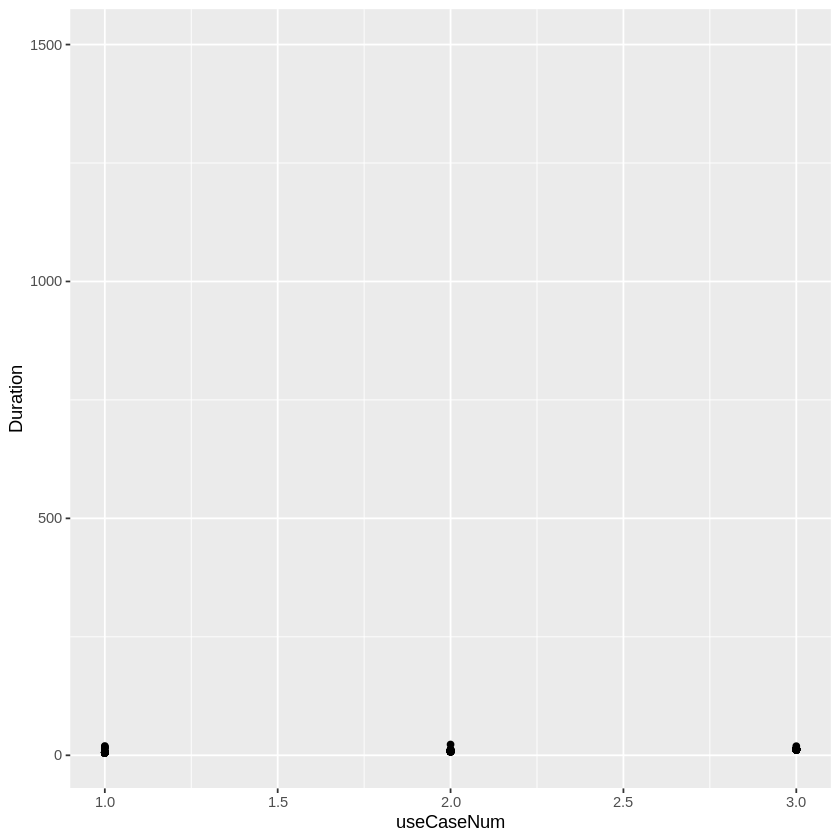

In [15]:
qplot(useCaseNum, Duration, data = spanMetrics)

In [16]:
# Remove outliers
aSpan <- spanMetrics
# outliers <- boxplot(aSpan$Duration, plot = FALSE)$out
# outliers

# aSpan <- aSpan[-which(aSpan$Duration %in% outliers),]

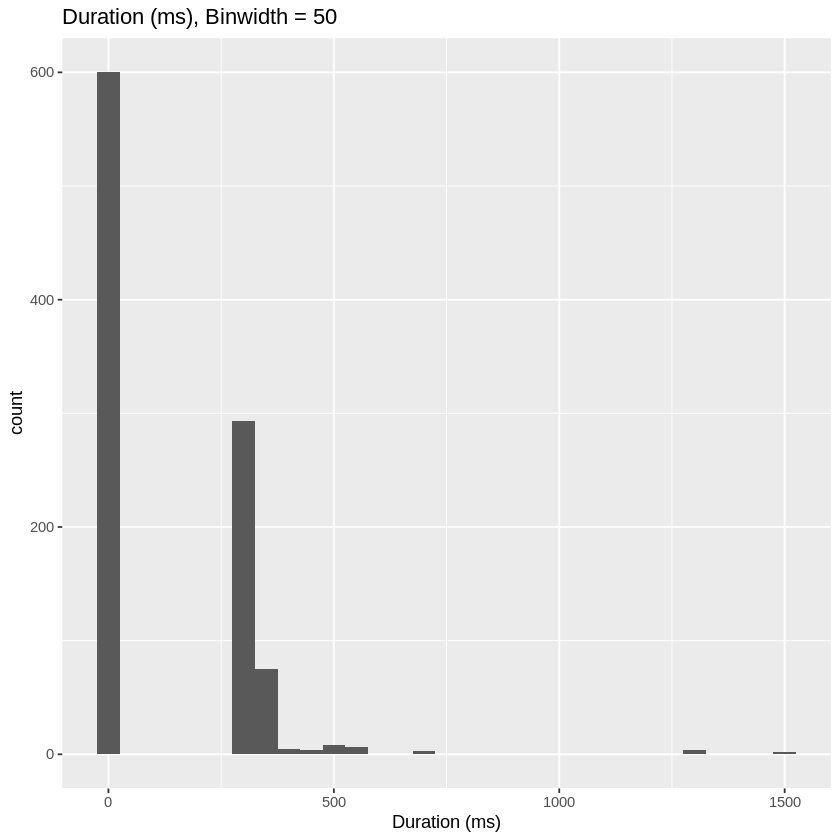

In [17]:
spanMetrics %>%
# aSpan %>%
    ggplot(aes(Duration)) + geom_histogram(binwidth = 50) +
    ggtitle("Duration (ms), Binwidth = 50") +
    xlab("Duration (ms)")

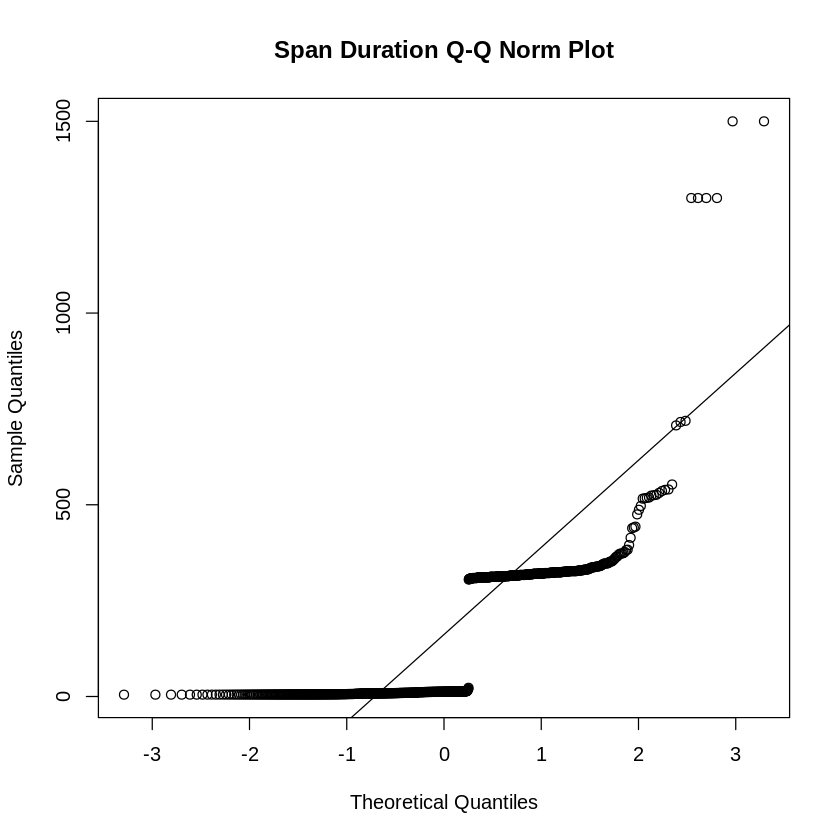

In [18]:
qqnorm(aSpan$Duration, main="Span Duration Q-Q Norm Plot")
qqline(aSpan$Duration)

In [19]:
# Separate Internal Data
# Could use ext == FALSE

tracksSpanData = subset(aSpan, useCaseNum == 1)
TE_SpanData = subset(aSpan, useCaseNum == 2)
WA_SpanData = subset(aSpan, useCaseNum == 3)

internalSpanData <- rbind(tracksSpanData, TE_SpanData, WA_SpanData)
# internalSpanData <- rbind(WA_SpanData)
dssSpanData <- rbind(TE_SpanData, WA_SpanData)

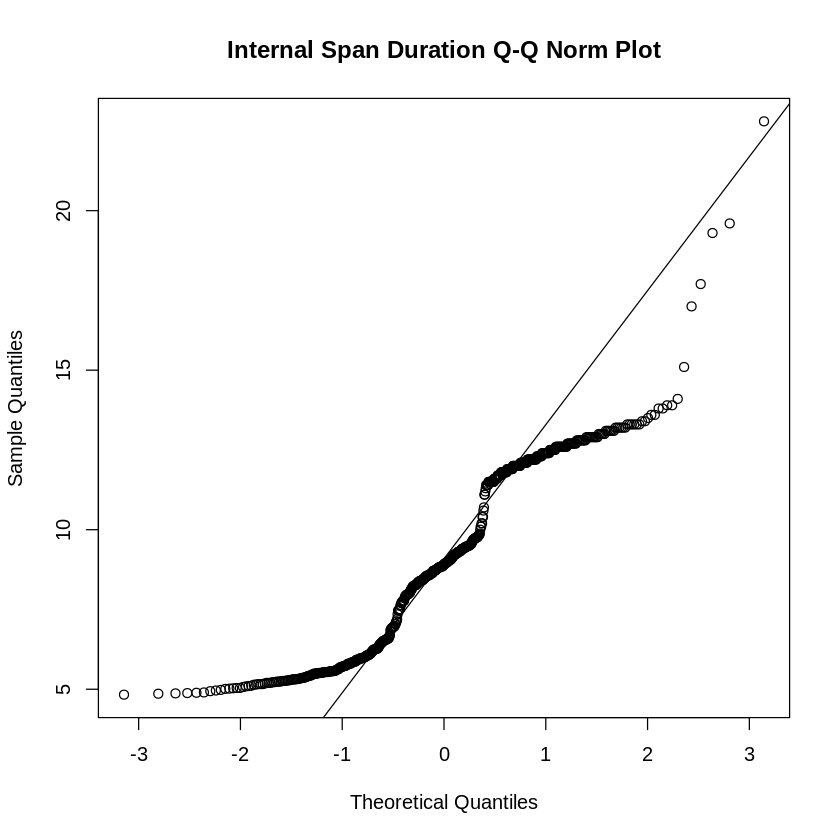

In [20]:
qqnorm(internalSpanData$Duration, main="Internal Span Duration Q-Q Norm Plot")
qqline(internalSpanData$Duration)

# qqnorm(dssSpanData$Duration, main="DSS Span Duration Q-Q Norm Plot")
# qqline(dssSpanData$Duration)

In [21]:
outliers <- which(internalSpanData$Duration > 50) #outlier rows
outliers
# iSpan <- internalSpanData[!outliers,]
# iSpan <- dssSpanData[!dssSpanData$Duration > 50,]
iSpan <- internalSpanData[!internalSpanData$Duration > 50,]
    # Remove if duration is greater than a value

integer(0)

In [22]:
# create min-max-norm function
min_max_norm <- function(x) {
    (x - min(x)) / (max(x) - min(x))
  }

#apply Min-Max normalization
norm_iSpan <- iSpan
norm_iSpan$Duration <- (iSpan$Duration - min(iSpan$Duration)) / 
    (max(iSpan$Duration) - min(iSpan$Duration))

summary(norm_iSpan)

   Trace.ID           Trace.name   Start.time           Duration      
 Length:600         /TE    :200   Length:600         Min.   :0.00000  
 Class :character   /tracks:200   Class :character   1st Qu.:0.07944  
 Mode  :character   /WA    :200   Mode  :character   Median :0.22677  
                                                     Mean   :0.24002  
                                                     3rd Qu.:0.39482  
                                                     Max.   :1.00000  
                                   useCase      useCaseNum    ext         
 Assess Weapons (Internal)             :200   Min.   :1    Mode :logical  
 Get Stored Local DSS Tracks (Internal):200   1st Qu.:1    FALSE:600      
 Trial Engage (Internal)               :200   Median :2                   
                                              Mean   :2                   
                                              3rd Qu.:3                   
                                              Max.   

In [23]:
log_iSpan <- iSpan
log_iSpan$Duration=log(log_iSpan$Duration + 1) # Natural Log
inv_iSpan <- iSpan
inv_iSpan$Duration = (1 / inv_iSpan$Duration)


	Shapiro-Wilk normality test

data:  log_iSpan$Duration
W = 0.93199, p-value = 7.054e-16



	Shapiro-Wilk normality test

data:  inv_iSpan$Duration
W = 0.90386, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  norm_iSpan$Duration
W = 0.92623, p-value < 2.2e-16


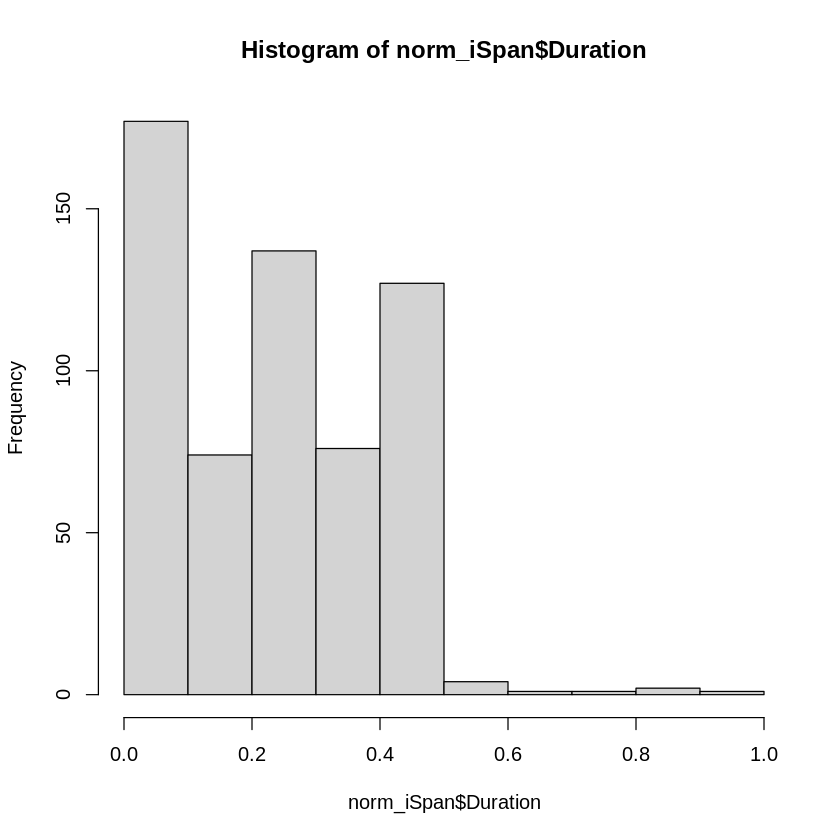

In [24]:
shapiro.test(log_iSpan$Duration)
shapiro.test(inv_iSpan$Duration)
shapiro.test(norm_iSpan$Duration)

hist(norm_iSpan$Duration)

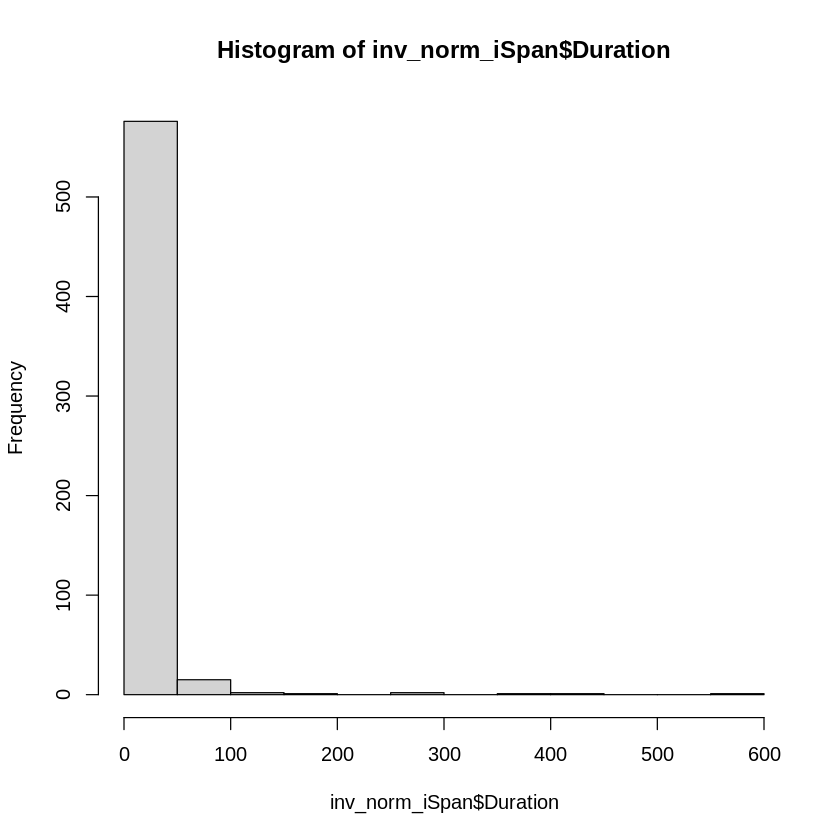


	Shapiro-Wilk normality test

data:  log_inv_norm_iSpan$Duration
W = NaN, p-value = NA


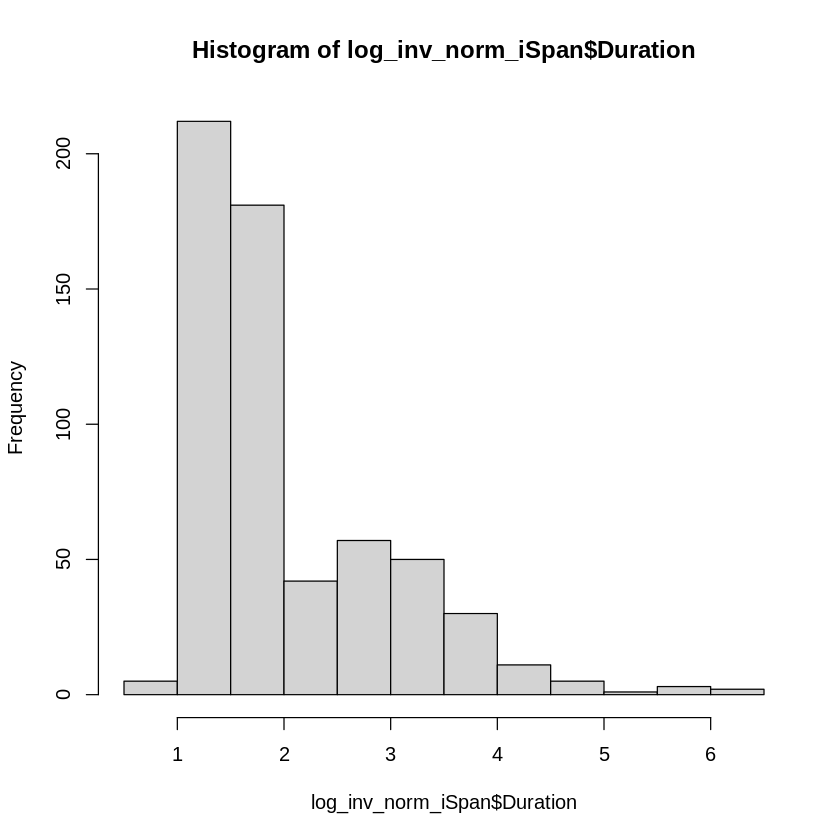

In [25]:
# log_norm_iSpan <- norm_iSpan
# log_norm_iSpan$Duration=log(log_norm_iSpan$Duration + 1)
# hist(log_norm_iSpan$Duration)
# shapiro.test(log_norm_iSpan$Duration)
# inv_log_norm_iSpan <- log_norm_iSpan
# inv_log_norm_iSpan$Duration = (1 / inv_log_norm_iSpan$Duration)
# hist(inv_log_norm_iSpan$Duration)

inv_norm_iSpan <- norm_iSpan
inv_norm_iSpan$Duration = (1 / inv_norm_iSpan$Duration)
hist(inv_norm_iSpan$Duration)

log_inv_norm_iSpan <- inv_norm_iSpan
log_inv_norm_iSpan$Duration=log(log_inv_norm_iSpan$Duration + 1)
hist(log_inv_norm_iSpan$Duration)
shapiro.test(log_inv_norm_iSpan$Duration)

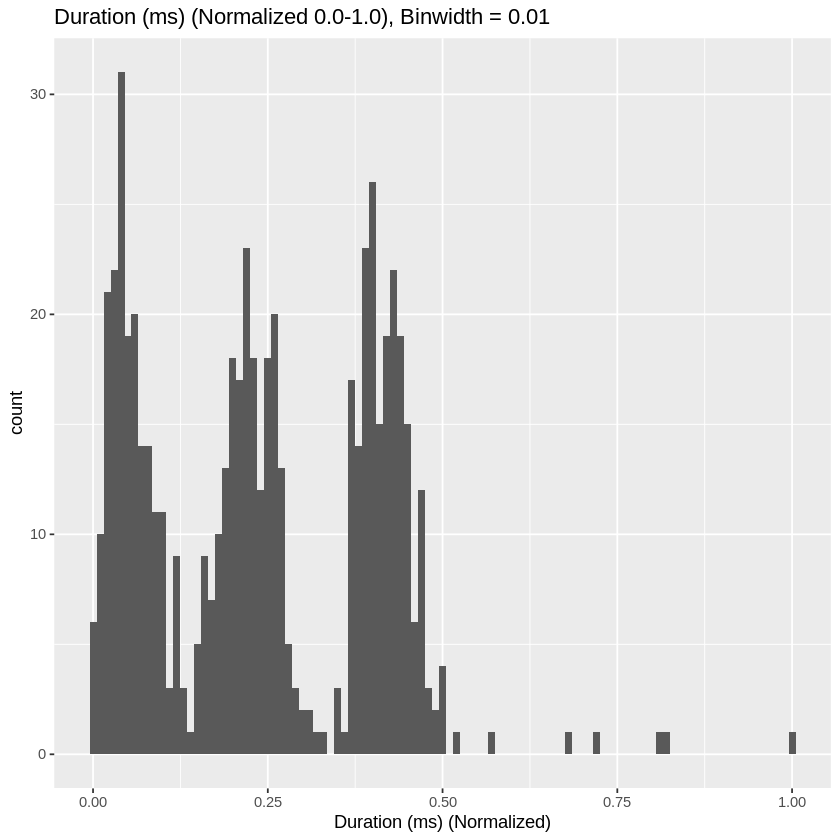

In [26]:
norm_iSpan %>%
# aSpan %>%
    ggplot(aes(Duration)) + geom_histogram(binwidth = 0.01) +
    ggtitle("Duration (ms) (Normalized 0.0-1.0), Binwidth = 0.01") +
    xlab("Duration (ms) (Normalized)")